# Penjelasan Dataset & Tugas Regresi
Dataset ini terdiri dari data performa ETF dan reksa dana yang beroperasi di Eropa. Saya akan melakukan tugas regresi dengan membuat model untuk memprediksi "long_term_projected_earnings_growth"

# Import Dataset & Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif
from sklearn.preprocessing import RobustScaler
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [ ]:
url = 'https://raw.githubusercontent.com/fauzanrrizky/datsci-datasets/main/EIM_Train.csv'
df = pd.read_csv(url)

# Functions

Fungsi-fungsi penting yang nantinya akan digunakan

In [ ]:
def evaluate_classifier_performance(prediction, y_test):
    # Informasi evaluasi secara compact
    print("Hasil Evaluasi berdasarkan classification report \n\n%s\n" % (classification_report(y_test, prediction,zero_division=0)))
    print()
    print("Confusion Matrix")
    print()
    y_actual = pd.Series(np.array(y_test), name = "actual")
    y_pred = pd.Series(np.array(prediction), name = "prediction")
    df_confusion = pd.crosstab(y_actual, y_pred)
    display(df_confusion)
    print()
    print()

    print("Butuh informasi lebih lengkap? silakan simak di bawah ini : ")
    print('Accuracy Average:', accuracy_score(y_test, prediction))
    print('F1 Macro Average:', f1_score(y_test, prediction, average='macro'))
    print('F1 Micro Average:', f1_score(y_test, prediction, average='micro'))
    print('Precision Macro Average:', precision_score(y_test, prediction, average='macro',zero_division=0))
    print('Precision Micro Average:', precision_score(y_test, prediction, average='micro',zero_division=0))
    print('Recall Macro Average:', recall_score(y_test, prediction, average='macro',zero_division=0))
    print('Recall Micro Average:', recall_score(y_test, prediction, average='micro',zero_division=0))
    print()

In [ ]:
# Missing Values
def get_missing_info(df):

    missing_values = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    missing_info = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Values': missing_values.values,
        'Missing Values Percentage': missing_percentage.values
    })

    missing_info = missing_info.sort_values(by='Missing Values Percentage', ascending=False)
    return missing_info

# Preprocessing
Tahapan preprocessing mulai dari penanganan data duplikat, data hilang, outliers, encoding & splitting data, normalisasi, feature selection, dan imbalance handling

## Data Duplikat

In [ ]:
# Duplicated Data Train
duplikat_train = df[df.duplicated()]
print(duplikat_train)

Empty DataFrame
Columns: [ticker, category, dividend_frequency, equity_style, equity_size, equity_size_score, price_prospective_earnings, price_book_ratio, price_sales_ratio, price_cash_flow_ratio, dividend_yield_factor, long_term_projected_earnings_growth, historical_earnings_growth, sales_growth, cash_flow_growth, book_value_growth, roa, roe, roic, bond_interest_rate_sensitivity, bond_credit_quality, average_coupon_rate, average_credit_quality, modified_duration, effective_maturity, asset_stock, asset_bond, asset_cash, asset_other, sector_basic_materials, sector_consumer_cyclical, sector_financial_services, sector_real_estate, sector_consumer_defensive, sector_healthcare, sector_utilities, sector_communication_services, sector_energy, sector_industrials, sector_technology, market_cap_giant, market_cap_large, market_cap_medium, market_cap_small, market_cap_micro, credit_aaa, credit_aa, credit_a, credit_bbb, credit_bb, credit_b, credit_below_b, credit_not_rated, holdings_n_stock, holdi

Tidak ada data duplikat

## Missing Values

In [ ]:
result_missing_info = get_missing_info(df)
print(result_missing_info)

                             Column  Missing Values  Missing Values Percentage
23                modified_duration           20692                  92.292596
24               effective_maturity           20529                  91.565566
20              bond_credit_quality           20133                  89.799286
19   bond_interest_rate_sensitivity           20133                  89.799286
52                 credit_not_rated           19897                  88.746655
..                              ...             ...                        ...
10            dividend_yield_factor               0                   0.000000
5                 equity_size_score               0                   0.000000
4                       equity_size               0                   0.000000
3                      equity_style               0                   0.000000
116                          rating               0                   0.000000

[117 rows x 3 columns]


Buat treshold missing values sebanyak 50%
Sayamm Menetapkan missing values treshold sebesar 50% karensayami meyakini data yang hilang di atas 50% sudah kehilangan sebagian besar informasinya. Menyimpan fitur tersebut mungkin hanya akan menambah noise dan tidak memberikan insight untuk membuat model prediktif

In [ ]:
# Tentukan batas persentase missing values
threshold_percentage = 50

# Pilih kolom-kolom yang memiliki missing values di atas threshold
columns_to_drop = result_missing_info[result_missing_info['Missing Values Percentage'] > threshold_percentage]['Column']

# Drop kolom-kolom tersebut dari DataFrame
df = df.drop(columns=columns_to_drop)

Selanjutnya, Saya mencari tahu dan membagi tipe data (numerical & categorical) untuk melakukan penanganan yang berbeda pada bagian imputasi data

In [ ]:
# numeric_cols = df.select_dtypes(include=['number'])
# categorical_cols = df.select_dtypes(exclude=['number'])

numerical_cols = list(df.select_dtypes(include=['number']).columns)
categorical_cols = list(df.select_dtypes(exclude=['number']).columns)

# Remove fitur ticker(identifier) dan rating(label feature)
categorical_cols.remove('ticker')
numerical_cols.remove('rating')

Selanjutnya, dilakukan imputasi Missing Values

Disini, Saya melakukan imputasi data dengan cara mengimputasi dengan nilai mean untuk kolom numerikal, dan nilai modus untuk kolom kategorikal. Namun, ada pengecualian untuk kolom sectors = ['sector_basic_materials','sector_consumer_cyclical', 'sector_financial_services',
             'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities',
             'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology'].

Saya mengisi data null untuk kolom 'sector_*' dengan 0, Alasan: Null disini artinya investment management tidak menginvestasikan uangnya di sektor tersebut.

In [ ]:
sectors = ['sector_basic_materials','sector_consumer_cyclical', 'sector_financial_services',
             'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities',
             'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology']

# Mengimputasi nilai 0 untuk missing value pada kolom-kolom sektor
for i in sectors:
    df[i].fillna(0, inplace=True)

# Mengimputasi nilai mean untuk missing value pada kolom numerik
for i in numerical_cols:
    mean_value = df[i].mean()
    df[i].fillna(mean_value, inplace=True)

# Mengimputasi nilai mean untuk missing value pada kolom kategorikal
for i in categorical_cols:
    mode_value = df[i].mode()[0]
    df[i].fillna(mode_value, inplace=True)

# Tampilkan DataFrame yang telah dibersihkan
result_missing_info = get_missing_info(df)
print(result_missing_info.to_string(index=False))

                             Column  Missing Values  Missing Values Percentage
                             ticker               0                        0.0
                    shareclass_size               0                        0.0
                   fund_return_2015               0                        0.0
                   fund_return_2016               0                        0.0
                   fund_return_2017               0                        0.0
                   fund_return_2018               0                        0.0
                   fund_return_2019               0                        0.0
        fund_trailing_return_5years               0                        0.0
        fund_trailing_return_3years               0                        0.0
           fund_trailing_return_ytd               0                        0.0
                          fund_size               0                        0.0
                 fund_size_currency               0 

Sudah tidak ada missing values

## Outliers

In [ ]:
# Check Outliers
# Variabel untuk outliers
Q3 = df.select_dtypes(include=['number']).quantile(0.75)
Q1 = df.select_dtypes(include=['number']).quantile(0.25)
IQR = Q3.subtract(Q1)

Jumlah_Outlier0 = []
pd.set_option('display.max_columns', None)
for col in df.select_dtypes(np.number).columns:
    outliers = ((df[col] < (Q1[col] - 1.5 * IQR[col])) | (df[col] > (Q3[col] + 1.5 * IQR[col]))).sum()
    Jumlah_Outlier0.append([col, outliers, outliers/len(df)])

indexOutput0 = list(range(0, len(Jumlah_Outlier0)))

pd.DataFrame(Jumlah_Outlier0, columns=['Column', 'Outlier','persentase'],index=indexOutput0).sort_values(by=['persentase'], ascending = False,ignore_index=True)

,Column,Outlier,persentase
0,asset_bond,5384,0.240143
1,asset_stock,4672,0.208385
2,involvement_palm_oil,4446,0.198305
3,fund_return_2015,4118,0.183675
4,asset_other,3848,0.171632
...,...,...,...
88,quarters_down,119,0.005308
89,ongoing_cost,65,0.002899
90,management_fees,61,0.002721
91,market_cap_giant,43,0.001918


Terlihat banyak kolom yang mengandung outliers, dengan 'asset_bond' dengan outliers tertinggi sebesar 24% dari keseluruhan data.

## Encoding & Splitting Data

In [ ]:
# Encoding
le = LabelEncoder()

df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col])

# # Lakukan encoding dengan manual (mapping)
# # Saya melakukan mapping kolom rating untuk mulai dari 0 karena, beberapa model klasifikasi membutuhkan class yang dimulai dari 0 (bukan 1)
# rating_map = {
#     1:0,
#     2:1,
#     3:2,
#     4:3,
#     5:4
# }
# df_encoded['rating'] = df_encoded['rating'].map(rating_map)

df_encoded.head()

,ticker,category,equity_style,equity_size,equity_size_score,price_prospective_earnings,price_book_ratio,price_sales_ratio,price_cash_flow_ratio,dividend_yield_factor,long_term_projected_earnings_growth,historical_earnings_growth,sales_growth,cash_flow_growth,book_value_growth,roa,roe,roic,asset_stock,asset_bond,asset_cash,asset_other,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology,market_cap_giant,market_cap_large,market_cap_medium,market_cap_small,market_cap_micro,holdings_n_stock,ongoing_cost,management_fees,environmental_score,social_score,governance_score,sustainability_score,sustainability_rank,sustainability_percentage_rank,involvement_abortive_contraceptive,involvement_alcohol,involvement_animal_testing,involvement_controversial_weapons,involvement_gambling,involvement_gmo,involvement_military_contracting,involvement_nuclear,involvement_palm_oil,involvement_pesticides,involvement_small_arms,involvement_thermal_coal,involvement_tobacco,nav_per_share_currency,nav_per_share,shareclass_size_currency,shareclass_size,fund_size_currency,fund_size,fund_trailing_return_ytd,fund_trailing_return_3years,fund_trailing_return_5years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2020_q3,fund_return_2020_q2,fund_return_2020_q1,fund_return_2019_q4,fund_return_2019_q3,fund_return_2019_q2,fund_return_2019_q1,fund_return_2018_q4,fund_return_2018_q3,fund_return_2018_q2,fund_return_2018_q1,fund_return_2017_q4,fund_return_2017_q3,fund_return_2017_q2,fund_return_2017_q1,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down,rating
0,0P000153IG,92,2,0,248.25,10.66,1.00,0.92,6.19,4.13,8.66,3.060000,4.72,0.16,2.75,6.38,14.04,11.80,98.55,0.00,1.45,0.00,14.17,2.35,18.69,0.00,4.31,9.30,0.00,9.28,7.74,23.95,10.21,30.75,39.04,16.80,10.69,2.72,45.0,1.136168,0.852358,6.16,8.72,8.73,24.38,1.0,89.0,9.67,2.86,11.77,0.00,0.00,0.00,0.00,1.37,0.0,0.00,0.00,0.00,0.00,7,241.84,10,261930000.0,9,6.566210e+09,1.40,2.08,10.280000,18.51,-11.31,15.240000,28.740000,2.064887,5.66,18.05,-24.50,2.42,-0.41,8.18,7.40,-14.03,5.37,5.56,-7.25,3.53,1.790000,1.950000,7.250000,6.060000,14.750000,1.85000,3.860000,8.010000,-8.180000,-4.630000,7.171196,16,6,3.0
1,F00000OUR6,186,0,1,124.69,23.06,1.97,1.70,12.07,1.30,9.34,14.300000,7.55,8.56,9.59,7.36,14.61,11.33,96.81,0.57,2.63,-0.01,8.17,14.42,18.82,0.00,2.96,15.34,1.59,0.00,0.00,17.32,21.39,1.14,0.00,66.33,32.53,0.00,57.0,0.840000,0.750000,5.31,8.85,7.16,26.08,2.0,78.0,3.93,0.00,14.93,0.00,0.00,0.00,4.91,0.00,0.0,2.38,0.00,1.59,0.00,16,3.96,14,17010000.0,12,7.717900e+08,1.65,6.66,12.090000,25.39,-5.72,1.740000,41.980000,7.120000,0.89,17.82,-24.09,0.12,4.68,8.60,10.16,-16.02,6.56,11.32,-5.35,5.29,-1.810000,-1.710000,0.120000,11.940000,8.640000,9.40000,6.720000,9.260000,-6.200000,-4.920000,9.930000,16,7,3.0
2,F00000OTTT,9,1,0,322.70,27.99,3.04,2.71,10.35,0.97,16.87,5.847373,13.80,21.53,14.76,7.83,16.35,11.62,95.92,0.00,2.21,1.87,6.35,22.32,10.82,0.44,11.74,3.37,0.00,17.14,0.00,4.39,23.42,62.38,21.08,11.85,3.33,1.37,40.0,1.018200,0.750000,4.23,8.38,6.99,24.98,4.0,44.0,0.26,0.00,2.83,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,7,2.32,6,30900000.0,6,1.282800e+08,45.43,13.19,18.480000,22.29,-19.51,29.120000,24.700000,-5.990000,17.13,27.23,-9.07,6.64,1.42,3.90,8.82,-7.94,-7.33,4.11,-9.37,9.92,0.800000,6.430000,9.500000,-2.930000,12.530000,6.06000,7.640000,7.340000,-10.010000,-10.820000,9.130000,16,7,4.0
3,F000005K32,183,2,0,229.67,17.19,1.77,0.75,6.52,2.73,7.77,3.170000,3.04,-0.32,1.86,4.68,17.51,8.65,99.98,0.00,0.21,-0.19,3.01,14.47,13.86,1.73,11.37,10.43,1.39,8.46,3.27,16.32,15.68,30.86,33.09,23.26,11.14,1.66,1106.0,0.550000,0.300000,4.39,9.91,7.06,23.50,2.0,79.0,7.35,

In [ ]:
# Splitting Data
X = df_encoded.drop(["long_term_projected_earnings_growth","ticker"],axis=1)
y = df_encoded["long_term_projected_earnings_growth"]

numerical_cols.remove("long_term_projected_earnings_growth")

# Melakukan splitting terhadap data train dan test (0.2 test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 123)

## Normalisasi (standarisasi) dengan Robust Scaler

Normalisasi hanya diimplementasikan kepada kolom numerik (tidak termasuk kolom kategorikal yang dilakukan encoding. Alasan menggunakan Robust Scaler: Data mengandung banyak outliers, Robust Scaler dirancang untuk lebih tahan terhadap outliers.

In [ ]:
scaled_train

,category,equity_style,equity_size,nav_per_share_currency,shareclass_size_currency,fund_size_currency,rating,equity_size_score_transformed,price_prospective_earnings_transformed,price_book_ratio_transformed,price_sales_ratio_transformed,price_cash_flow_ratio_transformed,dividend_yield_factor_transformed,historical_earnings_growth_transformed,sales_growth_transformed,cash_flow_growth_transformed,book_value_growth_transformed,roa_transformed,roe_transformed,roic_transformed,asset_stock_transformed,asset_bond_transformed,asset_cash_transformed,asset_other_transformed,sector_basic_materials_transformed,sector_consumer_cyclical_transformed,sector_financial_services_transformed,sector_real_estate_transformed,sector_consumer_defensive_transformed,sector_healthcare_transformed,sector_utilities_transformed,sector_communication_services_transformed,sector_energy_transformed,sector_industrials_transformed,sector_technology_transformed,market_cap_giant_transformed,market_cap_large_transformed,market_cap_medium_transformed,market_cap_small_transformed,market_cap_micro_transformed,holdings_n_stock_transformed,ongoing_cost_transformed,management_fees_transformed,environmental_score_transformed,social_score_transformed,governance_score_transformed,sustainability_score_transformed,sustainability_rank_transformed,sustainability_percentage_rank_transformed,involvement_abortive_contraceptive_transformed,involvement_alcohol_transformed,involvement_animal_testing_transformed,involvement_controversial_weapons_transformed,involvement_gambling_transformed,involvement_gmo_transformed,involvement_military_contracting_transformed,involvement_nuclear_transformed,involvement_palm_oil_transformed,involvement_pesticides_transformed,involvement_small_arms_transformed,involvement_thermal_coal_transformed,involvement_tobacco_transformed,nav_per_share_transformed,shareclass_size_transformed,fund_size_transformed,fund_trailing_return_ytd_transformed,fund_trailing_return_3years_transformed,fund_trailing_return_5years_transformed,fund_return_2019_transformed,fund_return_2018_transformed,fund_return_2017_transformed,fund_return_2016_transformed,fund_return_2015_transformed,fund_return_2020_q3_transformed,fund_return_2020_q2_transformed,fund_return_2020_q1_transformed,fund_return_2019_q4_transformed,fund_return_2019_q3_transformed,fund_return_2019_q2_transformed,fund_return_2019_q1_transformed,fund_return_2018_q4_transformed,fund_return_2018_q3_transformed,fund_return_2018_q2_transformed,fund_return_2018_q1_transformed,fund_return_2017_q4_transformed,fund_return_2017_q3_transformed,fund_return_2017_q2_transformed,fund_return_2017_q1_transformed,fund_return_2016_q4_transformed,fund_return_2016_q3_transformed,fund_return_2016_q2_transformed,fund_return_2016_q1_transformed,fund_return_2015_q4_transformed,fund_return_2015_q3_transformed,fund_return_2015_q2_transformed,fund_return_2015_q1_transformed,quarters_up_transformed,quarters_down_transformed
17758,154,2,0,16,14,5,2.0,-0.437675,-0.534859,-0.377984,-0.781794,-0.839614,1.255975,0.870686,-0.176342,-0.488121,-0.701499,-0.330048,-0.756271,-0.518165,0.508332,-0.352711,-0.194596,-0.391311,2.787890,-1.407474,-1.951182,-1.260590,-1.756080,-1.643411,-0.598088,-1.662102,2.403192,-1.821968,-1.631512,-0.378166,0.394795,0.311126,0.623925,0.210925,-0.472413,2.089451,1.177299,2.605554,0.318776,-1.267537,2.194114,-0.153073,0.843050,-0.340722,-1.035807,-0.752877,-0.851027,-0.842018,-0.408927,-0.987456,1.270812,-0.443551,-0.742585,-0.820389,1.964136,-0.854932,-1.168586,-0.968861,0.338769,-1.032510,-1.092127,0.268269,-0.980074,-0.647441,-0.632958,3.027162,-3.610643,-0.999236,1.112579,-1.390213,-0.536753,-2.070020,-0.558608,0.770373,-0.923577,-0.873518,2.008882,-1.336146,1.358593,1.724235,-2.663013,-1.448781,1.370363,1.658246,2.277032,2.128684,-2.034718,-3.064473,-0.092665,-2.795744,-1.201493,2.561048
9947,103,0,0,7,6,12,4.0,0.362945,0.653933,0.231573,0.178792,-0.016442,-0.505631,0.639732,0.093833,0.176912,0.291856,0.525703,0.871928,0.

In [ ]:
# Menggunakan RobustScaler pada data pelatihan (kolom numerik)
scaler_numeric = RobustScaler()

scaled_train = X_train.copy()
scaled_test = X_test.copy()

# Looping untuk melakukan Robust Scaling pada setiap kolom numerik
for col in numerical_cols:
    # Melakukan Robust Scaling pada kolom numerik
    scaled_train[col+'_scaled'] = scaler_numeric.fit_transform(scaled_train[[col]])
    scaled_test[col+'_scaled'] = scaler_numeric.transform(scaled_test[[col]])

# Hapus kolom numerik asli setelah scaling (opsional)
scaled_train.drop(numerical_cols, axis=1, inplace=True)
scaled_test.drop(numerical_cols, axis=1, inplace=True)

scaled_train

,category,equity_style,equity_size,nav_per_share_currency,shareclass_size_currency,fund_size_currency,rating,equity_size_score_scaled,price_prospective_earnings_scaled,price_book_ratio_scaled,price_sales_ratio_scaled,price_cash_flow_ratio_scaled,dividend_yield_factor_scaled,historical_earnings_growth_scaled,sales_growth_scaled,cash_flow_growth_scaled,book_value_growth_scaled,roa_scaled,roe_scaled,roic_scaled,asset_stock_scaled,asset_bond_scaled,asset_cash_scaled,asset_other_scaled,sector_basic_materials_scaled,sector_consumer_cyclical_scaled,sector_financial_services_scaled,sector_real_estate_scaled,sector_consumer_defensive_scaled,sector_healthcare_scaled,sector_utilities_scaled,sector_communication_services_scaled,sector_energy_scaled,sector_industrials_scaled,sector_technology_scaled,market_cap_giant_scaled,market_cap_large_scaled,market_cap_medium_scaled,market_cap_small_scaled,market_cap_micro_scaled,holdings_n_stock_scaled,ongoing_cost_scaled,management_fees_scaled,environmental_score_scaled,social_score_scaled,governance_score_scaled,sustainability_score_scaled,sustainability_rank_scaled,sustainability_percentage_rank_scaled,involvement_abortive_contraceptive_scaled,involvement_alcohol_scaled,involvement_animal_testing_scaled,involvement_controversial_weapons_scaled,involvement_gambling_scaled,involvement_gmo_scaled,involvement_military_contracting_scaled,involvement_nuclear_scaled,involvement_palm_oil_scaled,involvement_pesticides_scaled,involvement_small_arms_scaled,involvement_thermal_coal_scaled,involvement_tobacco_scaled,nav_per_share_scaled,shareclass_size_scaled,fund_size_scaled,fund_trailing_return_ytd_scaled,fund_trailing_return_3years_scaled,fund_trailing_return_5years_scaled,fund_return_2019_scaled,fund_return_2018_scaled,fund_return_2017_scaled,fund_return_2016_scaled,fund_return_2015_scaled,fund_return_2020_q3_scaled,fund_return_2020_q2_scaled,fund_return_2020_q1_scaled,fund_return_2019_q4_scaled,fund_return_2019_q3_scaled,fund_return_2019_q2_scaled,fund_return_2019_q1_scaled,fund_return_2018_q4_scaled,fund_return_2018_q3_scaled,fund_return_2018_q2_scaled,fund_return_2018_q1_scaled,fund_return_2017_q4_scaled,fund_return_2017_q3_scaled,fund_return_2017_q2_scaled,fund_return_2017_q1_scaled,fund_return_2016_q4_scaled,fund_return_2016_q3_scaled,fund_return_2016_q2_scaled,fund_return_2016_q1_scaled,fund_return_2015_q4_scaled,fund_return_2015_q3_scaled,fund_return_2015_q2_scaled,fund_return_2015_q1_scaled,quarters_up_scaled,quarters_down_scaled
17758,154,2,0,16,14,5,2.0,-0.407103,-0.429403,-0.226563,-0.405172,-0.504277,1.224490,1.057576,-0.095528,-0.618056,-0.703488,-0.267143,-0.637376,-0.464668,0.128355,0.000000,-0.102041,0.020690,9.258266,-1.079487,-1.652684,-0.527003,-1.035135,-1.066138,-0.472684,-1.206522,9.159524,-1.142695,-1.002051,-0.332474,0.330521,0.301240,0.590,1.000000,-0.094319,1.709020,0.957733,8.731481,0.283810,-1.891334,3.027354,0.000000,0.532614,-0.221906,-0.331429,-0.471019,0.000000,0.00,0.00,-0.236686,1.379509,0.00,0.000000,0.000000,4.266968,0.000000,-0.401426,-0.165483,0.294281,-0.991498,-1.032051,0.209229,-0.775231,-0.519441,-0.651641,5.319600,-7.825458,-0.922296,0.931125,-1.204941,-0.513021,-1.653631,-0.482192,0.605634,-0.669004,-0.775556,1.458529,-1.178451,1.069124,2.175258,-2.852912,-1.074766,1.284896,1.549961,2.733515,3.225789,-1.840004,-4.680020,-0.159872,-4.220744,-1.00,1.666667
9947,103,0,0,7,6,12,4.0,0.266369,0.572052,0.171875,0.120690,-0.025214,-0.341837,0.693939,0.221545,0.244792,0.438372,0.392857,0.715347,0.723769,0.180863,0.000000,-0.201166,-0.048276,-0.096515,-0.129487,0.183632,0.306231,0.414865,0.333911,0.456057,-0.192029,0.200000,0.002265,0.195489,0.276804,0.434049,-0.365623,-0.058,0.064748,0.597356,-0.303922,-0.306667,-0.250000,0.266111,-0.460778,-0.557753,0.000000,-0.092386,0.574680,-0.171429,0.501666,1.380435,0.00,0.00,0.840237,0.917749,0.00,0.000000,0.000000,0.719457,0.000000,-0.417151,-0.163361,-0.278463,0.500283,0.727564,0.747729,0.412345,0.121143,-0.216640,0.647453,0.5471

## Yeo-Johnson Transform

Kami juga mencoba mengurangi dampak outliers dengan melakukan transformasi data dengan metode yeo-johnson.
Alasan Menggunakan Yeo-Johnson Transform:
- Data mengandung nilai nol dan nilai negatif
- Lebih tahan dan mampu menangani outliers
- Fleksibel dalam menangani berbagai jenis distribusi data

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Membuat objek PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Looping untuk melakukan Yeo-Johnson Transform pada setiap kolom numerik
for col in numerical_cols:
    # Melakukan Yeo-Johnson Transform pada kolom numerik
    col_transformed = pt.fit_transform(scaled_train[[col+'_scaled']])
    scaled_train[col+'_transformed'] = col_transformed

    col_transformed_test = pt.transform(scaled_test[[col+'_scaled']])
    scaled_test[col+'_transformed'] = col_transformed_test

    # Hapus kolom numerik asli setelah scaling (opsional)
    scaled_train.drop(col+'_scaled', axis=1, inplace=True)
    scaled_test.drop(col+'_scaled', axis=1, inplace=True)

scaled_train

,category,equity_style,equity_size,nav_per_share_currency,shareclass_size_currency,fund_size_currency,rating,equity_size_score_transformed,price_prospective_earnings_transformed,price_book_ratio_transformed,price_sales_ratio_transformed,price_cash_flow_ratio_transformed,dividend_yield_factor_transformed,historical_earnings_growth_transformed,sales_growth_transformed,cash_flow_growth_transformed,book_value_growth_transformed,roa_transformed,roe_transformed,roic_transformed,asset_stock_transformed,asset_bond_transformed,asset_cash_transformed,asset_other_transformed,sector_basic_materials_transformed,sector_consumer_cyclical_transformed,sector_financial_services_transformed,sector_real_estate_transformed,sector_consumer_defensive_transformed,sector_healthcare_transformed,sector_utilities_transformed,sector_communication_services_transformed,sector_energy_transformed,sector_industrials_transformed,sector_technology_transformed,market_cap_giant_transformed,market_cap_large_transformed,market_cap_medium_transformed,market_cap_small_transformed,market_cap_micro_transformed,holdings_n_stock_transformed,ongoing_cost_transformed,management_fees_transformed,environmental_score_transformed,social_score_transformed,governance_score_transformed,sustainability_score_transformed,sustainability_rank_transformed,sustainability_percentage_rank_transformed,involvement_abortive_contraceptive_transformed,involvement_alcohol_transformed,involvement_animal_testing_transformed,involvement_controversial_weapons_transformed,involvement_gambling_transformed,involvement_gmo_transformed,involvement_military_contracting_transformed,involvement_nuclear_transformed,involvement_palm_oil_transformed,involvement_pesticides_transformed,involvement_small_arms_transformed,involvement_thermal_coal_transformed,involvement_tobacco_transformed,nav_per_share_transformed,shareclass_size_transformed,fund_size_transformed,fund_trailing_return_ytd_transformed,fund_trailing_return_3years_transformed,fund_trailing_return_5years_transformed,fund_return_2019_transformed,fund_return_2018_transformed,fund_return_2017_transformed,fund_return_2016_transformed,fund_return_2015_transformed,fund_return_2020_q3_transformed,fund_return_2020_q2_transformed,fund_return_2020_q1_transformed,fund_return_2019_q4_transformed,fund_return_2019_q3_transformed,fund_return_2019_q2_transformed,fund_return_2019_q1_transformed,fund_return_2018_q4_transformed,fund_return_2018_q3_transformed,fund_return_2018_q2_transformed,fund_return_2018_q1_transformed,fund_return_2017_q4_transformed,fund_return_2017_q3_transformed,fund_return_2017_q2_transformed,fund_return_2017_q1_transformed,fund_return_2016_q4_transformed,fund_return_2016_q3_transformed,fund_return_2016_q2_transformed,fund_return_2016_q1_transformed,fund_return_2015_q4_transformed,fund_return_2015_q3_transformed,fund_return_2015_q2_transformed,fund_return_2015_q1_transformed,quarters_up_transformed,quarters_down_transformed
17758,154,2,0,16,14,5,2.0,-0.437675,-0.534859,-0.377984,-0.781794,-0.839614,1.255975,0.870686,-0.176342,-0.488121,-0.701499,-0.330048,-0.756271,-0.518165,0.508332,-0.352711,-0.194596,-0.391311,2.787890,-1.407474,-1.951182,-1.260590,-1.756080,-1.643411,-0.598088,-1.662102,2.403192,-1.821968,-1.631512,-0.378166,0.394795,0.311126,0.623925,0.210925,-0.472413,2.089451,1.177299,2.605554,0.318776,-1.267537,2.194114,-0.153073,0.843050,-0.340722,-1.035807,-0.752877,-0.851027,-0.842018,-0.408927,-0.987456,1.270812,-0.443551,-0.742585,-0.820389,1.964136,-0.854932,-1.168586,-0.968861,0.338769,-1.032510,-1.092127,0.268269,-0.980074,-0.647441,-0.632958,3.027162,-3.610643,-0.999236,1.112579,-1.390213,-0.536753,-2.070020,-0.558608,0.770373,-0.923577,-0.873518,2.008882,-1.336146,1.358593,1.724235,-2.663013,-1.448781,1.370363,1.658246,2.277032,2.128684,-2.034718,-3.064473,-0.092665,-2.795744,-1.201493,2.561048
9947,103,0,0,7,6,12,4.0,0.362945,0.653933,0.231573,0.178792,-0.016442,-0.505631,0.639732,0.093833,0.176912,0.291856,0.525703,0.871928,0.

## Feature Selection

Selain menetapkan missing values treshold sebesar 50%, kami juga menggunakan SelectKBest, dengan k sebanyak 50: Didapat dengan melakukan eksperimen, k=50 memiliki running time yang tidak terlalu lama dan akurasi relatif tinggi.

In [ ]:
# Feature Selection

select = SelectKBest(score_func=f_regression, k=50)
z = select.fit_transform(scaled_train,y_train)

filter = select.get_support()
selected_features  = array(scaled_train.columns)

# Drop columns from X_train that are not among the selected best 30 features
selected_columns = scaled_train.columns[filter]
X_train_selected = scaled_train[selected_columns]
scaled_test = scaled_test[selected_columns]

X_train_selected

,equity_style,equity_size,rating,price_prospective_earnings_transformed,price_book_ratio_transformed,dividend_yield_factor_transformed,historical_earnings_growth_transformed,sales_growth_transformed,cash_flow_growth_transformed,book_value_growth_transformed,roe_transformed,sector_consumer_cyclical_transformed,sector_financial_services_transformed,sector_real_estate_transformed,sector_consumer_defensive_transformed,sector_utilities_transformed,sector_energy_transformed,sector_technology_transformed,market_cap_large_transformed,market_cap_small_transformed,market_cap_micro_transformed,holdings_n_stock_transformed,ongoing_cost_transformed,management_fees_transformed,sustainability_score_transformed,involvement_abortive_contraceptive_transformed,involvement_animal_testing_transformed,involvement_controversial_weapons_transformed,involvement_nuclear_transformed,involvement_small_arms_transformed,involvement_thermal_coal_transformed,involvement_tobacco_transformed,fund_trailing_return_ytd_transformed,fund_trailing_return_3years_transformed,fund_trailing_return_5years_transformed,fund_return_2018_transformed,fund_return_2017_transformed,fund_return_2020_q3_transformed,fund_return_2020_q2_transformed,fund_return_2019_q4_transformed,fund_return_2019_q3_transformed,fund_return_2018_q4_transformed,fund_return_2018_q3_transformed,fund_return_2017_q4_transformed,fund_return_2017_q3_transformed,fund_return_2017_q2_transformed,fund_return_2017_q1_transformed,fund_return_2016_q4_transformed,fund_return_2016_q3_transformed,fund_return_2015_q2_transformed
17758,2,0,2.0,-0.534859,-0.377984,1.255975,0.870686,-0.176342,-0.488121,-0.701499,-0.756271,-1.407474,-1.951182,-1.260590,-1.756080,-0.598088,2.403192,-1.631512,0.394795,0.623925,0.210925,-0.472413,2.089451,1.177299,2.194114,-0.340722,-0.752877,-0.851027,1.270812,-0.820389,1.964136,-0.854932,-1.032510,-1.092127,0.268269,-0.647441,-0.632958,-0.999236,1.112579,-0.536753,-2.070020,-0.923577,-0.873518,1.358593,1.724235,-2.663013,-1.448781,1.370363,1.658246,-0.092665
9947,0,0,4.0,0.653933,0.231573,-0.505631,0.639732,0.093833,0.176912,0.291856,0.871928,-0.009331,0.290985,0.516473,0.538954,0.174130,0.391363,0.422818,0.496100,-0.384173,-0.432678,0.696399,-0.509473,-0.523353,-0.432719,0.773785,0.692061,1.272001,1.001434,-0.820389,0.932916,-0.854932,0.503409,0.626649,0.804120,0.054478,-0.137245,0.253017,0.191117,0.075752,0.203145,-0.908423,1.063297,0.463852,0.182041,-0.360837,-0.434513,1.268754,0.199580,-0.585318
3540,2,1,3.0,0.362140,0.010053,0.922435,0.087262,-0.673787,-1.793101,-0.483564,-1.094439,-1.971953,-1.951182,0.544865,-1.756080,6.099791,1.892991,-1.631512,0.503606,-0.206743,-0.495766,-1.087298,-0.133238,0.060295,0.662436,-1.488772,-1.638240,-0.851027,2.011086,-0.820389,2.320078,-0.854932,-0.818701,-0.480181,0.050813,0.020038,-1.499878,-1.349309,-1.393819,-0.886319,0.607700,0.876738,-0.751827,-2.066331,-1.451445,-0.499074,0.024687,-0.488872,-1.002296,0.058446
10278,1,2,5.0,1.403712,1.340583,-2.322718,0.783691,0.230887,0.206652,0.948066,-2.309914,-0.379539,-1.288265,0.395730,-0.888590,-0.598088,-0.371783,1.505348,-2.239956,2.025206,1.145484,0.590616,0.891607,1.180045,1.055104,0.262078,1.105278,-0.851027,-0.927824,-0.820389,-1.068555,0.637012,1.037187,1.365138,1.098892,1.021273,-0.145798,0.091586,1.594370,-0.237121,-0.929187,-1.966277,1.331861,-0.358473,0.077996,0.112587,-0.128824,0.059200,0.476395,0.231868
18696,2,0,3.0,-0.328587,-0.436462,1.163764,-1.709286,-0.915665,-0.199926,0.106267,0.150849,0.068550,0.143806,-0.630291,1.987762,0.218881,1.073589,-1.218125,-0.373277,0.768927,-0.329078,-0.640270,-0.492455,-0.225180,-0.223423,1.212023,1.612587,-0.851027,-0.927824,-0.820389,0.907635,1.792921,-1.354790,-0.834646,-1.339260,-0.547595,-0.230874,-1.310648,-0.716076,0.599184,0.317428,-0.151785,-0.881247,-0.284901,0.247723,0.148983,-0.569784,0.057119,-0.160241,0.833554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Pembuatan Model

Selanjutnya, Saya mencoba untuk menggunakan beberapa model untuk mendapatkan model dengan hasil yang terbaik

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Inisialisasi model Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_selected, y_train)

y_pred_linear = linear_model.predict(scaled_test)

y_pred_linear

array([9.25494674, 7.94488272, 8.94197779, ..., 8.79899273, 8.06416527,
       6.72217003])

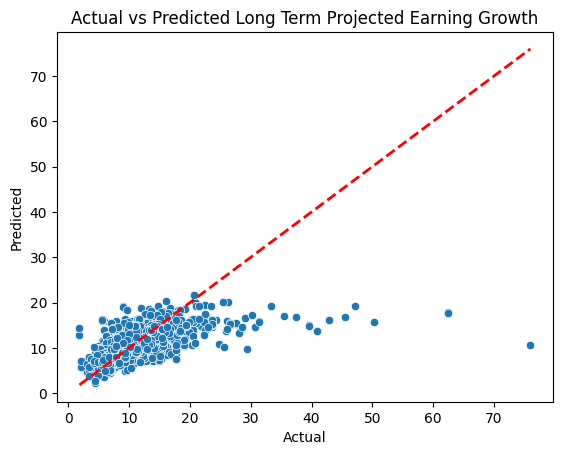

In [ ]:
# Visualisasi perbandingan hasil prediksi dengan aktual

import matplotlib.pyplot as plt

# # Visualisasi hasil prediksi
plt.figure
sns.scatterplot(x=y_test, y=y_pred_linear)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Long Term Projected Earning Growth')

# Menampilkan plot
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, y_pred_linear)
mse = mean_squared_error(y_test, y_pred_linear)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_linear)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}\n")

MAE: 1.7324536046490382, MSE: 9.391924055978786, RMSE: 3.0646246190975472, R-squared: 0.40118781709145257



## Lasso Regression

List alpha yang berisi beberapa alpha untuk percobaan mencari alpha terbaik

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

alpha_values = [0.001, 0.01, 0.05, 0.10, 0.20]

In [ ]:
lasso_models = []
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_selected, y_train)
    lasso_models.append(lasso)

Tampilkan hasil MAE, MSE, RMSE, dan R-Squared untuk masing-masing model lasso regression dengan alpha yang berbeda

In [ ]:
for lasso in lasso_models:
    y_pred_lasso = lasso.predict(scaled_test)
    mae = mean_absolute_error(y_test, y_pred_lasso)
    mse = mean_squared_error(y_test, y_pred_lasso)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_lasso)
    print(f"Alpha: {lasso.alpha}\nMAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}\n")

Alpha: 0.001
MAE: 1.7316226483602128, MSE: 9.391961273299462, RMSE: 3.064630691176257, R-squared: 0.4011854441820357

Alpha: 0.01
MAE: 1.7247174337347764, MSE: 9.409612263703062, RMSE: 3.0675091301743604, R-squared: 0.40006004878583357

Alpha: 0.05
MAE: 1.721908099352552, MSE: 9.654655736212213, RMSE: 3.1071941902964824, R-squared: 0.38443651778131216

Alpha: 0.1
MAE: 1.735193125712271, MSE: 9.968636898537408, RMSE: 3.157314824108836, R-squared: 0.3644176436844305

Alpha: 0.2
MAE: 1.771578613292883, MSE: 10.464930586057493, RMSE: 3.2349544952066163, R-squared: 0.33277485093863



Model terbaik berdasarkan nilai R-squared pada Lasso Regression

In [ ]:
best_lasso = max(lasso_models, key=lambda l: r2_score(y_test, l.predict(scaled_test)))
print(best_lasso)

Lasso(alpha=0.001)


Tampilkan array hasil prediksi model regresi lasso dengan alpha terbaik

In [ ]:
y_pred_lasso_best = best_lasso.predict(scaled_test)
print("Prediksi dari Model Terbaik:", y_pred_lasso_best)

Prediksi dari Model Terbaik: [9.25317491 7.95683661 8.93852157 ... 8.79380596 8.06447786 6.70327518]


Visualisasikan

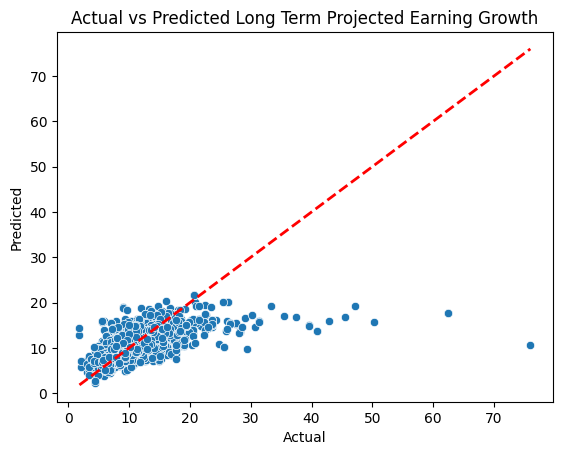

In [ ]:
# Visualisasi perbandingan hasil prediksi dengan aktual

import matplotlib.pyplot as plt

# # Visualisasi hasil prediksi
plt.figure
sns.scatterplot(x=y_test, y=y_pred_lasso_best)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Long Term Projected Earning Growth')

# Menampilkan plot
plt.show()

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

alpha_values = [0.001, 0.01, 0.05, 0.10, 0.20]

In [ ]:
ridge_models = []
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_selected, y_train)
    ridge_models.append(ridge)

In [ ]:
for ridge in ridge_models:
    y_pred_ridge = ridge.predict(scaled_test)
    mae = mean_absolute_error(y_test, y_pred_ridge)
    mse = mean_squared_error(y_test, y_pred_ridge)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_ridge)
    print(f"Alpha: {ridge.alpha}\nMAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}\n")

Alpha: 0.001
MAE: 1.7324535901044873, MSE: 9.391924066413031, RMSE: 3.064624620799916, R-squared: 0.40118781642618384

Alpha: 0.01
MAE: 1.7324534592038847, MSE: 9.39192416033263, RMSE: 3.064624636123098, R-squared: 0.4011878104380393

Alpha: 0.05
MAE: 1.732452877431056, MSE: 9.391924578000928, RMSE: 3.0646247042665644, R-squared: 0.4011877838082599

Alpha: 0.1
MAE: 1.7324521502325319, MSE: 9.391925100655302, RMSE: 3.0646247895387293, R-squared: 0.4011877504847572

Alpha: 0.2
MAE: 1.7324506958938477, MSE: 9.391926147860216, RMSE: 3.0646249603924156, R-squared: 0.40118768371685576



Pilih model terbaik, dan visualisasikan

In [ ]:
best_ridge = max(ridge_models, key=lambda r: r2_score(y_test, r.predict(scaled_test)))
print(best_ridge)

Ridge(alpha=0.001)


In [ ]:
y_pred_ridge_best = best_ridge.predict(scaled_test)
print("Prediksi dari Model Terbaik:", y_pred_ridge_best)

Prediksi dari Model Terbaik: [9.25494652 7.94488257 8.94197754 ... 8.79899291 8.06416539 6.72216977]


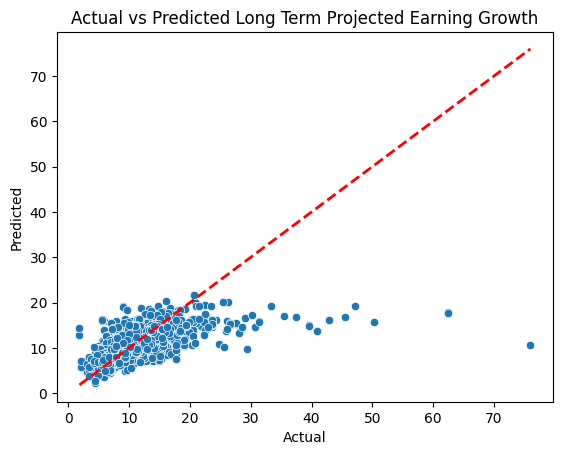

In [ ]:
# Visualisasi perbandingan hasil prediksi dengan aktual

import matplotlib.pyplot as plt

# # Visualisasi hasil prediksi
plt.figure
sns.scatterplot(x=y_test, y=y_pred_ridge_best)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Long Term Projected Earning Growth')

# Menampilkan plot
plt.show()

## Random Forest Regression

In [ ]:
# Inisialisasi model Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=999)

# Melatih model pada data latih
rf_regressor.fit(X_train_selected, y_train)

RandomForestRegressor(random_state=999)

In [ ]:
# Membuat prediksi pada data uji
y_pred_rf = rf_regressor.predict(scaled_test)

In [ ]:
# Mengukur performa model
r2 = r2_score(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf)  # RMSE = sqrt(MSE)
mae = mean_absolute_error(y_test, y_pred_rf)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

R-squared: 0.9081484772095232
Mean Squared Error: 1.4406228715722567
Root Mean Squared Error: 1.4406228715722567
Mean Absolute Error: 0.3142130017841222


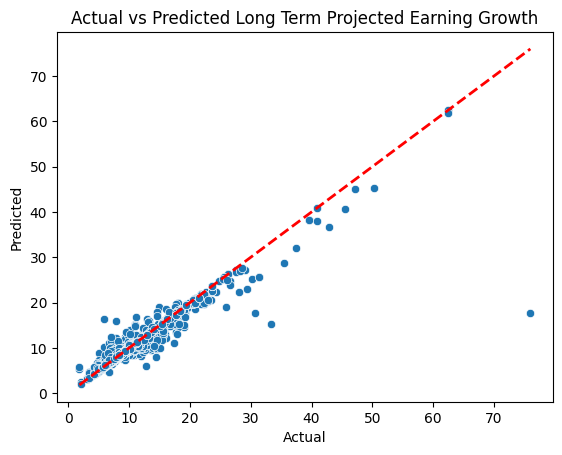

In [ ]:
# Visualisasi perbandingan hasil prediksi dengan aktual

import matplotlib.pyplot as plt

# # Visualisasi hasil prediksi
plt.figure
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Long Term Projected Earning Growth')

# Menampilkan plot
plt.show()

# Hasil Analisis

Didapatkan model yang mengeluarkan hasil terbaik pada dataset ini adalah random
forest regression.